In [18]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime


In [19]:
# ------------------------------------
# 1) Define your portfolio tickers
# ------------------------------------

# Define your portfolio tickers
portfolio_ticker = [
    "AAPL", "JPM", "NFLX", "CSCO", "GE", "DHR", "ANET", "UNP", "FI", "VRTX",
    "NVDA", "LLY", "BAC", "MS", "AMD", "INTU", "C", "UBER", "MU", "MRVL",
    "MSFT", "V", "JNJ", "NOW", "ABT", "PLTR", "PFE", "CMCSA", "LMT", "SBUX",
    "GOOG", "XOM", "CRM", "AXP", "GS", "VZ", "LOW", "KKR", "PANW", "MMC",
    "AMZN", "MA", "ABBV", "BX", "DIS", "BKNG", "AMGN", "SCHW", "APP", "NKE",
    "META", "UNH", "CVX", "TMO", "PM", "RTX", "SYK", "TJX", "GILD", "PLD",
    "TSLA", "ORCL", "KO", "ISRG", "ADBE", "T", "NEE", "COP", "BMY", "LRCX",
    "AVGO", "COST", "WFC", "IBM", "CAT", "AMAT", "BSX", "BA", "UPS", "KLAC",
    "BRK-B", "HD", "TMUS", "PEP", "QCOM", "SPGI", "HON", "DE", "GEV", "CHTR",
    "WMT", "PG", "MRK", "MCD", "TXN", "BLK", "PGR", "ADP", "ADI", "CEG"
]


In [20]:
# ------------------------------------
# 2) Signal generation function
# ------------------------------------
def signal_generator(df):
    """
    Given two consecutive rows (df.iloc[0] and df.iloc[1]),
    return:
        1 for a Bearish pattern  (Sell),
        2 for a Bullish pattern (Buy),
        0 otherwise.
    """
    # Extract scalar values (ensure they're floats)
    open_price     = float(df.iloc[1]["Open"])
    close_price    = float(df.iloc[1]["Close"])
    previous_open  = float(df.iloc[0]["Open"])
    previous_close = float(df.iloc[0]["Close"])

    # Bearish Pattern
    if (open_price > close_price
        and previous_open < previous_close
        and close_price < previous_open
        and open_price >= previous_close):
        return 1  # Bearish (Sell signal)

    # Bullish Pattern
    elif (open_price < close_price
          and previous_open > previous_close
          and close_price > previous_open
          and open_price <= previous_close):
        return 2  # Bullish (Buy signal)

    # No clear pattern
    else:
        return 0

In [21]:
# ------------------------------------
# 3) Fetch data from yfinance
# ------------------------------------
def fetch_data(ticker, interval, period):
    """
    Fetch historical stock data for a given ticker using Yahoo Finance.
    """
    try:
        stock = yf.Ticker(ticker)
        print(f"📥 Fetching historical data for {ticker}...")
        data = stock.history(interval=interval, period=period)  

        if data.empty:
            print(f"⚠️ No data found for {ticker}.")
            return None
        return data

    except Exception as e:
        print(f"❌ Could not fetch data for {ticker}: {e}")
        return None


In [60]:
# ------------------------------------
# 4) Generate and recive signals from the data
# ------------------------------------
def evaluate_algorithm(interval='60m', period="1mo"):
    """
    Evaluate trading signals for all tickers in the portfolio.
    """
    failed_tickers = []
    evaluation_results = {}
    price_data = {}

    for ticker in portfolio_ticker:
        dataF = fetch_data(ticker, interval, period)

        # ✅ Check for missing data
        if dataF is None or dataF.empty or len(dataF) < 2:
            print(f"⚠️ Not enough data for {ticker}. Skipping.")
            failed_tickers.append(ticker)
            continue

        # ✅ Generate signals
        signals = [0]  # First row can't have a signal
        for i in range(1, len(dataF)):
            df_slice = dataF.iloc[i - 1: i + 1]
            signals.append(signal_generator(df_slice))

        dataF["Signal"] = signals

        # ✅ Save data with signals
        price_data[ticker] = dataF[["Close", "Signal"]]
        evaluation_results[ticker] = {
            "Total Signals": dataF["Signal"].value_counts().to_dict(),
            "Latest Signal": dataF["Signal"].iloc[-1]
        }

        print(f"✅ Processed {ticker}: {evaluation_results[ticker]}")

    # ✅ Summary of failed tickers
    if failed_tickers:
        print(f"\n⚠️ Failed to process: {failed_tickers}")

    return price_data  # Dictionary with ticker-wise time series




In [61]:
# ------------------------------------
# 5) Prompt for portfolio size
# ------------------------------------
def get_portfolio_size():
    """
    Prompt user for a portfolio size and convert it to float.
    Retries if user does not provide a valid number.
    """
    while True:
        try:
            val = float(input("Enter the value of your portfolio: "))
            return val
        except ValueError:
            print("That's not a number! Try again.\n")

In [87]:
# ------------------------------------
# 6) Dynamic portfolio alocation following
# the long or short signals for every stock 
# ------------------------------------

def apply_risk_management(ticker, holdings, close_price, buy_price, cash_balance, stop_loss=0.90, take_profit=1.15):
    """
    Applies risk management to open positions.
    - Stop-Loss: Sells if the price drops 5% from buy price.
    - Take-Profit: Sells if the price gains 10% from buy price.
    - Returns updated holdings and cash balance.
    """
    if holdings[ticker] > 0:  # Check if we have an open position
        if close_price <= buy_price * stop_loss:
            print(f"🔴 STOP-LOSS triggered for {ticker} at {close_price}")
            cash_balance += holdings[ticker] * close_price
            holdings[ticker] = 0  # Sell everything
        
        elif close_price >= buy_price * take_profit:
            print(f"🟢 TAKE-PROFIT triggered for {ticker} at {close_price}")
            cash_balance += holdings[ticker] * close_price
            holdings[ticker] = 0  # Sell everything

    return holdings, cash_balance


In [88]:
def track_portfolio_over_time(price_data, initial_capital, stop_loss=0.90, take_profit=1.15):
    """
    Simulates portfolio performance over time with:
    - Stop-Loss & Take-Profit rules
    - Dynamic capital allocation
    - Tracks portfolio value, composition, and asset value
    """
    portfolio_value_data = []
    portfolio_composition_data = []
    asset_value_data = []

    cash_balance = float(initial_capital)
    holdings = {ticker: 0 for ticker in price_data.keys()}
    buy_prices = {ticker: 0 for ticker in price_data.keys()}  # Track buy prices

    all_dates = sorted(set(date for data in price_data.values() for date in data.index))
    position_size = 0.10  # Invest 10% of available capital per trade

    for date in all_dates:
        date = pd.Timestamp(date)
        total_value = cash_balance

        daily_holdings = {ticker: 0 for ticker in price_data.keys()}
        daily_asset_values = {ticker: 0 for ticker in price_data.keys()}

        # ✅ Check active buy signals
        active_buy_signals = sum(1 for t in price_data if price_data[t].loc[date, "Signal"] == 2)

        for ticker, data in price_data.items():
            if date not in data.index:
                continue  # Skip missing data

            close_price = float(data.loc[date, "Close"])
            signal = int(data.loc[date, "Signal"])

            # ✅ Apply Risk Management
            holdings, cash_balance = apply_risk_management(
                ticker, holdings, close_price, buy_prices[ticker], cash_balance, stop_loss, take_profit
            )

            # ✅ Execute Buy/Sell Trades
            if signal == 2 and cash_balance > 0:  # Buy Signal
                if active_buy_signals > 0:
                    shares_to_buy = (cash_balance * position_size) / close_price
                    holdings[ticker] += shares_to_buy
                    buy_prices[ticker] = close_price  # Track buy price
                    cash_balance -= shares_to_buy * close_price

            elif signal == 1:  # Sell Signal
                cash_balance += holdings[ticker] * close_price
                holdings[ticker] = 0

            total_value += holdings[ticker] * close_price
            daily_holdings[ticker] = holdings[ticker]
            daily_asset_values[ticker] = holdings[ticker] * close_price

        # ✅ Compute percentage allocation
        allocation = {
            ticker: (holdings[ticker] * close_price) / total_value if total_value > 0 else 0
            for ticker in holdings
        }

        # ✅ Store daily portfolio data
        portfolio_value_data.append({
            "Date": date,
            "Portfolio Value": total_value,
            "Cash Balance": cash_balance
        })

        portfolio_composition_data.append({
            "Date": date,
            **daily_holdings,
            **{f"Alloc_{ticker}": round(alloc, 4) for ticker, alloc in allocation.items()}
        })

        asset_value_data.append({
            "Date": date,
            **daily_asset_values
        })

    # ✅ Convert to DataFrames
    portfolio_value_df = pd.DataFrame(portfolio_value_data).set_index("Date")
    portfolio_composition_df = pd.DataFrame(portfolio_composition_data).set_index("Date")
    asset_value_df = pd.DataFrame(asset_value_data).set_index("Date")

    return portfolio_value_df, portfolio_composition_df, asset_value_df


In [ ]:
# ------------------------------------
# 7) Dynamic portfolio alocation following
# the long or short signals for every stock 
# ------------------------------------

def track_portfolio_over_time(price_data, initial_capital):
    """
    Simulates portfolio performance over time.
    - Tracks daily portfolio value and composition separately.
    - Adjusts holdings based on buy/sell signals.
    - Logs changes in cash balance, asset allocation, and asset value.
    """
    portfolio_value_data = []
    portfolio_composition_data = []
    asset_value_data = []  # New table to track total value of each asset
    
    cash_balance = float(initial_capital)  # Ensure cash is a float
    holdings = {ticker: 0 for ticker in price_data.keys()}  # Start with 0 shares

    # Get all unique dates from all assets
    all_dates = sorted(set(date for data in price_data.values() for date in data.index))

    for date in all_dates:
        date = pd.Timestamp(date)  # Ensure the date is a pandas Timestamp
        total_value = cash_balance  # Start with available cash

        # Track daily holdings and asset values
        daily_holdings = {ticker: 0 for ticker in price_data.keys()}
        daily_asset_values = {ticker: 0 for ticker in price_data.keys()}

        for ticker, data in price_data.items():
            if date not in data.index:
                continue  # Skip missing data

            close_price = float(data.loc[date, "Close"])  # Ensure a float value
            
            # Ensure "Signal" is a single scalar value
            signal_value = data.loc[date, "Signal"]
            if isinstance(signal_value, pd.Series):  
                signal_value = signal_value.iloc[0]
            signal = int(signal_value)  # Convert to integer

            # ✅ Dynamic Allocation Based on Active Signals
            active_buy_signals = sum(1 for t in price_data if price_data[t].loc[date, "Signal"] == 2)
            position_size = 0.10  # Allocate 25% of cash per position

            if signal == 2 and cash_balance > 0:
                # Buy only if there are active buy signals
                if active_buy_signals > 0:
                    shares_to_buy = (cash_balance * position_size) / close_price
                    holdings[ticker] += shares_to_buy
                    cash_balance -= shares_to_buy * close_price

            elif signal == 1:
                # Sell fully if a sell signal is triggered
                cash_balance += holdings[ticker] * close_price
                holdings[ticker] = 0

            # Compute total portfolio value
            total_value += holdings[ticker] * close_price
            daily_holdings[ticker] = holdings[ticker]  # Track number of shares
            daily_asset_values[ticker] = holdings[ticker] * close_price  # Track asset value

        # Compute percentage allocation
        allocation = {
            ticker: (holdings[ticker] * price_data[ticker].loc[date, "Close"]) / total_value 
            if total_value > 0 else 0
            for ticker in holdings
        }

        # Store daily portfolio value
        portfolio_value_data.append({
            "Date": date,
            "Portfolio Value": total_value,
            "Cash Balance": cash_balance
        })

        # Store daily portfolio composition
        portfolio_composition_data.append({
            "Date": date,
            **daily_holdings,  # Number of shares per asset
            **{f"Alloc_{ticker}": round(alloc, 4) for ticker, alloc in allocation.items()}  # Clean % Allocation
        })

        # Store daily asset value
        asset_value_data.append({
            "Date": date,
            **daily_asset_values  # Total value of each asset
        })

    # Convert lists to DataFrames
    portfolio_value_df = pd.DataFrame(portfolio_value_data).set_index("Date")
    portfolio_composition_df = pd.DataFrame(portfolio_composition_data).set_index("Date")
    asset_value_df = pd.DataFrame(asset_value_data).set_index("Date")  # New table

    return portfolio_value_df, portfolio_composition_df, asset_value_df  # Return three tables




In [ ]:
# ------------------------------------
# 8) Run everything and build the portfolio value frame
# ------------------------------------

def main():
    # Fetch signals and price data
    price_data = evaluate_algorithm()

    # Ask user for initial capital
    initial_capital = get_portfolio_size()

    # Track portfolio performance over time
    portfolio_value_df, portfolio_composition_df, asset_value_df = track_portfolio_over_time(price_data, initial_capital)

    # Calculate returns
    portfolio_value_df["Daily Return"] = portfolio_value_df["Portfolio Value"].pct_change()
    portfolio_value_df["Cumulative Return"] = (1 + portfolio_value_df["Daily Return"]).cumprod()

    print("\n📊 Portfolio Value Evolution:")
    print(portfolio_value_df.tail())  # Show last few days of total portfolio value

    print("\n📈 Portfolio Composition Over Time:")
    print(portfolio_composition_df.tail())  # Show last few days of portfolio allocation

    print("\n💰 Asset Value Over Time:")
    print(asset_value_df.tail())  # Show last few days of asset values

    return portfolio_value_df, portfolio_composition_df, asset_value_df  # Return all three tables




In [89]:
def main():
    # Fetch signals and price data
    price_data = evaluate_algorithm()

    # Ask user for initial capital
    initial_capital = get_portfolio_size()

    # Define risk management parameters
    stop_loss = 0.90   # 5% loss limit
    take_profit = 1.15  # 10% profit target

    # Track portfolio performance with risk management
    portfolio_value_df, portfolio_composition_df, asset_value_df = track_portfolio_over_time(
        price_data, initial_capital, stop_loss, take_profit
    )

    # Calculate returns
    portfolio_value_df["Daily Return"] = portfolio_value_df["Portfolio Value"].pct_change()
    portfolio_value_df["Cumulative Return"] = (1 + portfolio_value_df["Daily Return"]).cumprod()

    print("\n📊 Portfolio Value Evolution:")
    print(portfolio_value_df.tail())  # Show last few days of total portfolio value

    print("\n📈 Portfolio Composition Over Time:")
    print(portfolio_composition_df.tail())  # Show last few days of portfolio allocation

    print("\n💰 Asset Value Over Time:")
    print(asset_value_df.tail())  # Show last few days of asset values

    return portfolio_value_df, portfolio_composition_df, asset_value_df  # Return all three tables




In [90]:
portfolio_value_df, portfolio_composition_df, asset_value_df = main()

📥 Fetching historical data for AAPL...
✅ Processed AAPL: {'Total Signals': {0: 134, 2: 10, 1: 10}, 'Latest Signal': 2}
📥 Fetching historical data for JPM...
✅ Processed JPM: {'Total Signals': {0: 138, 1: 8, 2: 8}, 'Latest Signal': 0}
📥 Fetching historical data for NFLX...
✅ Processed NFLX: {'Total Signals': {0: 138, 1: 8, 2: 8}, 'Latest Signal': 0}
📥 Fetching historical data for CSCO...
✅ Processed CSCO: {'Total Signals': {0: 139, 2: 11, 1: 4}, 'Latest Signal': 0}
📥 Fetching historical data for GE...
✅ Processed GE: {'Total Signals': {0: 143, 1: 6, 2: 5}, 'Latest Signal': 0}
📥 Fetching historical data for DHR...
✅ Processed DHR: {'Total Signals': {0: 139, 1: 9, 2: 6}, 'Latest Signal': 0}
📥 Fetching historical data for ANET...
✅ Processed ANET: {'Total Signals': {0: 143, 1: 8, 2: 3}, 'Latest Signal': 0}
📥 Fetching historical data for UNP...
✅ Processed UNP: {'Total Signals': {0: 137, 1: 10, 2: 7}, 'Latest Signal': 0}
📥 Fetching historical data for FI...
✅ Processed FI: {'Total Signals':

In [91]:
portfolio_value_df

,Portfolio Value,Cash Balance,Daily Return,Cumulative Return
Date,,,,
2025-01-15 09:30:00-05:00,100000.000000,100000.000000,NaN,NaN
2025-01-15 10:30:00-05:00,127100.000000,72900.000000,0.271000,1.271000
2025-01-15 11:30:00-05:00,144639.198974,28242.953648,0.137995,1.446392
2025-01-15 12:30:00-05:00,121070.213754,7178.979877,-0.162950,1.210702
2025-01-15 13:30:00-05:00,93090.777706,14112.813921,-0.231101,0.930908
...,...,...,...,...
2025-02-14 11:30:00-05:00,106394.057472,9158.746342,0.004229,1.063941
2025-02-14 12:30:00-05:00,107008.913179,8864.535211,0.005779,1.070089
2025-02-14 13:30:00-05:00,101394.555084,14151.082871,-0.052466,1.013946


In [92]:
portfolio_composition_df

,AAPL,JPM,NFLX,CSCO,GE,DHR,ANET,UNP,FI,VRTX,...,Alloc_WMT,Alloc_PG,Alloc_MRK,Alloc_MCD,Alloc_TXN,Alloc_BLK,Alloc_PGR,Alloc_ADP,Alloc_ADI,Alloc_CEG
Date,,,,,,,,,,,,,,,,,,,,,
2025-01-15 09:30:00-05:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0
2025-01-15 10:30:00-05:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.2118,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0
2025-01-15 11:30:00-05:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.1864,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0
2025-01-15 12:30:00-05:00,11.890268,0.000000,0.000000,42.234207,0.000000,0.0,0.0,0.000000,0.000000,5.431337,...,0.2211,0.0000,0.0000,0.0070,0.0000,0.0000,0.0,0.0000,0.0000,0.0
2025-01-15 13:30:00-05:00,11.890268,0.000000,0.000000,42.234207,0.000000,0.0,0.0,0.000000,0.000000,5.431337,...,0.2858,0.0000,0.0000,0.0091,0.0000,0.0000,0.0,0.0000,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-14 11:30:00-05:00,7.919088,12.799805,0.586939,50.422879,14.720096,0.0,0.0,1.101958,4.037278,0.000000,...,0.0000,0.0036,0.0000,0.0064,0.0245,0.0039,0.0,0.0192,0.0111,0.0
2025-02-14 12:30:00-05:00,7.919088,0.000000,0.586939,50.422879,14.720096,0.0,0.0,1.101958,4.037278,0.000000,...,0.0000,0.0036,0.0000,0.0064,0.0244,0.0039,0.0,0.0192,0.0247,0.0
2025-02-14 13:30:00-05:00,7.919088,3.189198,0.586939,50.422879,14.720096,0.0,0.0,1.101958,4.037278,0.000000,...,0.0000,0.0038,0.0000,0.0067,0.0000,0.0000,0.0,0.0000,0.0260,0.0


In [85]:
asset_value_df

,AAPL,JPM,NFLX,CSCO,GE,DHR,ANET,UNP,FI,VRTX,...,WMT,PG,MRK,MCD,TXN,BLK,PGR,ADP,ADI,CEG
Date,,,,,,,,,,,,,,,,,,,,,
2025-01-15 09:30:00-05:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
2025-01-15 10:30:00-05:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,8100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
2025-01-15 11:30:00-05:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,8116.891886,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
2025-01-15 12:30:00-05:00,2824.295365,0.000000,0.000000,2541.865828,0.000000,0.0,0.0,0.000000,0.000000,2287.679245,...,8139.562040,0.000000,0.000000,797.664431,0.000000,0.000000,0.0,0.000000,0.000000,0.0
2025-01-15 13:30:00-05:00,2824.653328,0.000000,0.000000,2540.598693,0.000000,0.0,0.0,0.000000,0.000000,2293.386393,...,8126.226376,0.000000,0.000000,799.079181,0.000000,0.000000,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-14 11:30:00-05:00,1941.945081,3565.847600,593.748606,3235.881599,3023.513176,0.0,0.0,274.539892,915.495997,0.000000,...,0.000000,198.063902,0.000000,662.447546,1539.227401,1250.155158,0.0,1953.733396,829.487989,0.0
2025-02-14 12:30:00-05:00,1943.416123,0.000000,597.028485,3247.256033,3033.873768,0.0,0.0,274.244500,914.843637,0.000000,...,0.000000,197.740322,0.000000,662.318883,1539.394853,1251.061314,0.0,1956.639743,1941.000628,0.0
2025-02-14 13:30:00-05:00,1944.611649,999.697108,598.226469,3260.477889,3036.062516,0.0,0.0,273.954567,914.151700,0.000000,...,0.000000,196.799553,0.000000,661.493242,0.000000,0.000000,0.0,0.000000,1938.003628,0.0


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

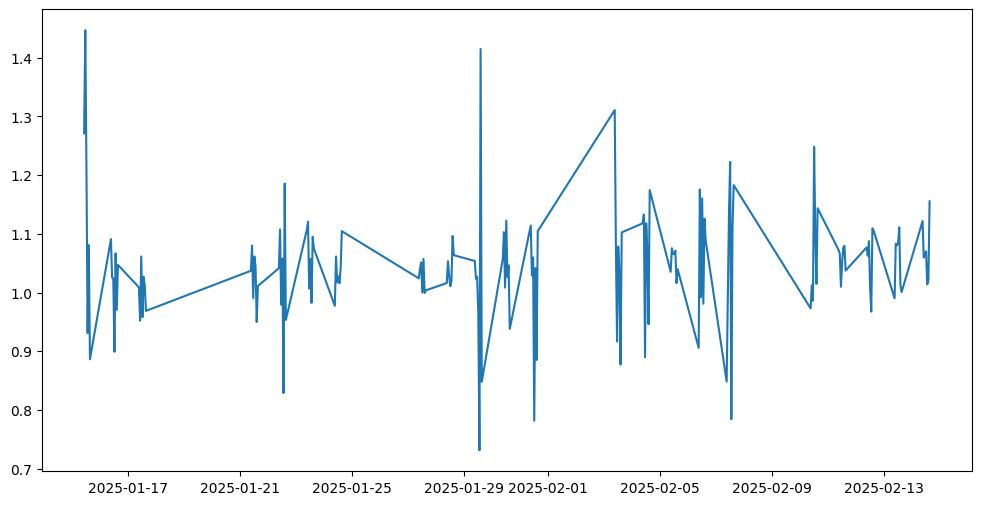

In [93]:
# ------------------------------------
# 8) Algorithm Evaluation
# ------------------------------------

import matplotlib.pyplot as plt

# Returns plot

plt.figure(figsize=(12, 6))
plt.plot(portfolio_value_df["Cumulative Return"], label="Portfolio Cumulative Return")
plt.plot

<Axes: title={'center': 'Portfolio t Return'}, xlabel='Date'>

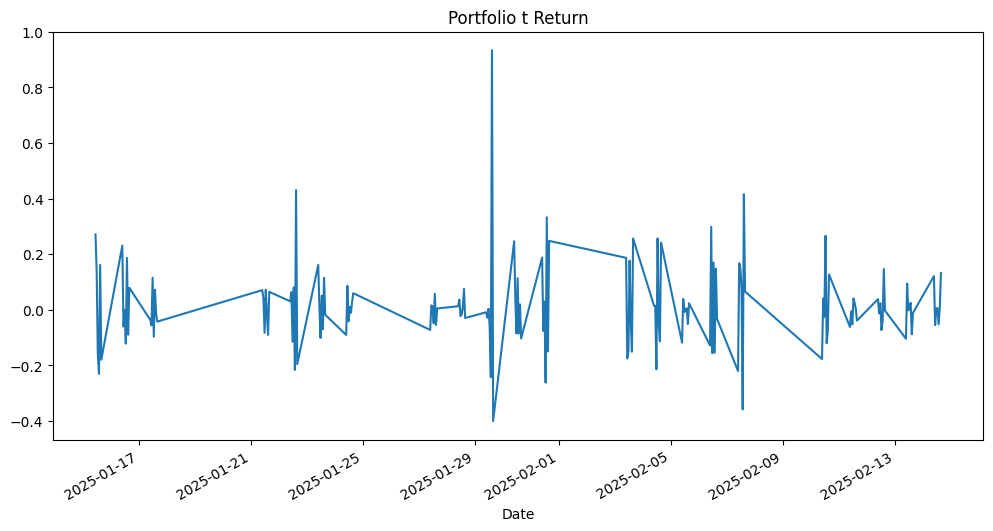

In [94]:
portfolio_value_df["Daily Return"].plot(figsize=(12, 6), title="Portfolio t Return")

In [96]:
portfolio_value_df.describe()

,Portfolio Value,Cash Balance,Daily Return,Cumulative Return
count,154.000000,154.000000,153.000000,153.000000
mean,104461.866699,11981.790512,0.011600,1.044910
std,9690.298116,11979.563970,0.153303,0.097153
min,73147.432637,297.302013,-0.400530,0.731474
25%,100439.282333,5724.398094,-0.072700,1.006604
50%,104540.667769,8867.421654,0.002972,1.046190
75%,108651.437823,13705.298387,0.071709,1.087404
max,144639.198974,100000.000000,0.933721,1.446392
